In [1]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    saved_model = "/artifacts/cifar10_32pipeline/1599/unet"
    class_num = 102
    batch_size= 256
    seed = 24


config = TrainingConfig()

In [2]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.CenterCrop(config.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 256, 256, 256),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "UpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    ),
)

In [4]:
import torch
import torch.nn as nn
class NewModel(nn.Module):
    def __init__(self, conv_in, time_proj, down_blocks, mid_block, dtype, time_embedding, config):
        super(NewModel, self).__init__()
        self.conv_in=conv_in
        self.time_proj=time_proj
        self.down_blocks = down_blocks
        self.mid_block = mid_block
        self.dtype=dtype
        self.time_embedding=time_embedding
        self.config=config

    def forward(self, sample):
        # 0. center input if necessary
        if self.config.center_input_sample:
            sample = 2 * sample - 1.0
        timesteps = 0
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        timesteps = timesteps * torch.ones(sample.shape[0], dtype=timesteps.dtype, device=timesteps.device)
        t_emb = self.time_proj(timesteps)
        t_emb = t_emb.to(dtype=self.dtype)
        emb = self.time_embedding(t_emb)


        # print("time done")
        # 2. pre-process
        skip_sample = sample
        sample = self.conv_in(sample)
        # print("pre-process done")
        # 3. down
        down_block_res_samples = (sample,)
        for downsample_block in self.down_blocks:
            if hasattr(downsample_block, "skip_conv"):
                sample, res_samples, skip_sample = downsample_block(
                    hidden_states=sample, temb=emb, skip_sample=skip_sample
                )
            else:
                sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

            down_block_res_samples += res_samples
        # print("down done")
        # 4. mid
        sample = self.mid_block(sample, emb)

        # Return the output from the mid-block
        return sample

In [5]:
Unet = UNet2DModel.from_pretrained(config.saved_model)
AlteredUnetModel=NewModel(Unet.conv_in, Unet.time_proj, Unet.down_blocks,Unet.mid_block, Unet.dtype, Unet.time_embedding, Unet.config)

In [6]:
from PIL import Image
image_path = '/artifacts/Testimages/flower.jpg'
image = Image.open(image_path)
image_tensor = preprocess(image).unsqueeze(0)

In [7]:
# Feed the image through the modified model
with torch.no_grad():
    mid_block_output = AlteredUnetModel(image_tensor)

# Inspect the output
print(mid_block_output.shape)

torch.Size([1, 256, 4, 4])


In [8]:
from torchvision import datasets
datasetCIFAR10 = datasets.CIFAR10(root='/artifacts/datasetcifar10train', train=True, download=True, transform=preprocess)
datasetCIFAR10test = datasets.CIFAR10(root='/artifacts/datasetcifar10test', train=False, download=True, transform=preprocess)
datasetFlower = datasets.Flowers102(root='/artifacts/datasetflowerstrain', download=True, split="train", transform=preprocess)
datasetFlowerval = datasets.Flowers102(root='/artifacts/datasetflowersval', download=True, split="val", transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
dataloader_train = torch.utils.data.DataLoader(
    datasetCIFAR10,
    batch_size=config.batch_size,
    shuffle=True
)
dataloader_val = torch.utils.data.DataLoader(
    datasetCIFAR10test,
    batch_size=config.batch_size,
    shuffle=False,
)

In [21]:
import numpy as np
from torch.nn import AdaptiveAvgPool2d
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

global_avg_pool = AdaptiveAvgPool2d((1, 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AlteredUnetModel.to(device)

# Extract features from your training set
features = []
for image, label in dataloader_train:
    image = image.to(device)
    label = label.to(device)
    with torch.no_grad():
        output = AlteredUnetModel(image)
        pooled_output = global_avg_pool(output)
        # Ensure the pooled output is flattened before converting to NumPy
        pooled_output_flattened = pooled_output.view(pooled_output.size(0), -1).cpu().numpy()
        features.append(pooled_output_flattened)

# Convert list of features to a numpy array
features = np.vstack(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42).fit(features)

In [23]:
val_features = []
val_true_labels = [] # Initialize a list to store the true labels
for image, label in dataloader_val:
    image = image.to(device)
    with torch.no_grad():
        output = AlteredUnetModel(image)
        pooled_output = global_avg_pool(output)
        pooled_output_flattened = pooled_output.view(pooled_output.size(0), -1).cpu().numpy()
        val_features.append(pooled_output_flattened)
        val_true_labels.extend(label.cpu().numpy()) # Store the true labels

# Convert list of features to a numpy array
val_features = np.vstack(val_features)

# Predict cluster labels for the validation set
val_cluster_labels = kmeans.predict(val_features)

# Compute the confusion matrix
cm = confusion_matrix(val_true_labels, val_cluster_labels)

In [24]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[317  51  23 116 314  92  17  29  30  11]
 [153 168  87 144  33 182  57  38  88  50]
 [169  74  66  42  78 101 125 191 111  43]
 [124  95  94  46  16 128 128 100 133 136]
 [ 75  67 180  43  30  90 132 231 110  42]
 [113  63 104  44  13 108 108 154  90 203]
 [ 82  49  75  20   9 103 224 244 144  50]
 [104 112 144  63  17 247  77 119  53  64]
 [213  73  35 320 197  77  10  13  29  33]
 [145 187  41 206  31 262  42  28  16  42]]


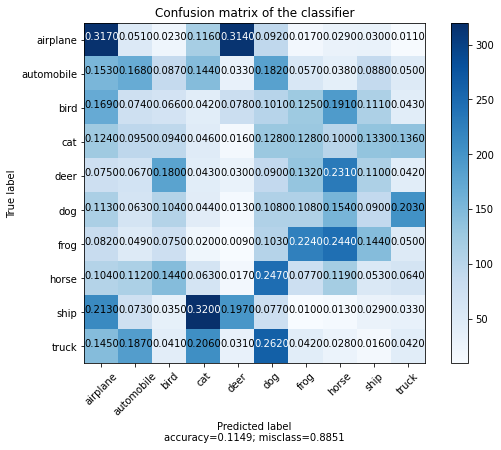

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                 the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                 see http://matplotlib.org/examples/color/colormaps_reference.html
                 plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                 If True, plot the proportions
    """
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Assuming you have already computed the confusion matrix `cm` and true labels `val_true_labels`
# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Compute the accuracy and misclassification rate
accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names, title='Confusion matrix of the classifier', normalize=True)
